<a href="https://colab.research.google.com/github/nikhilgunti/Skin-Cancer-Detection/blob/master/Skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)

In [7]:
image_dir = "/content/drive/My Drive/Spring_2020/NN/Skin_Cancer"

print(image_dir)

/content/drive/My Drive/Spring_2020/NN/Skin_Cancer


Merging all the images from zip folders into one dictionary and defining the lesion dictionary

In [0]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(image_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [9]:
print(imageid_path_dict)

{'ISIC_0028909': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028909.jpg', 'ISIC_0028787': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028787.jpg', 'ISIC_0028910': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028910.jpg', 'ISIC_0028788': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028788.jpg', 'ISIC_0028911': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028911.jpg', 'ISIC_0028789': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028789.jpg', 'ISIC_0028912': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028912.jpg', 'ISIC_0028790': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028790.jpg', 'ISIC_0028850': '/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0028850.jpg', 'ISIC_002

In [10]:
image_dataframe = pd.read_csv('/content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_metadata.csv')
image_dataframe.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
image_dataframe['path'] = image_dataframe['image_id'].map(imageid_path_dict.get)
image_dataframe['cell_type'] = image_dataframe['dx'].map(lesion_type_dict.get) 
image_dataframe['cell_type_idx'] = pd.Categorical(image_dataframe['cell_type']).codes
image_dataframe['path'].head(5)

0    /content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0027419.jpg
1    /content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0025030.jpg
2    /content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0026769.jpg
3    /content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_1/ISIC_0025661.jpg
4    /content/drive/My Drive/Spring_2020/NN/Skin_Cancer/HAM10000_images_part_2/ISIC_0031633.jpg
Name: path, dtype: object

#Image Pre-Processing
Resizing of images and loading into dataframe

In [0]:
image_dataframe.isnull().sum()
image_dataframe['age'].fillna((image_dataframe['age'].mean()), inplace=True)
image_dataframe.isnull().sum()

#Image Preprocessing
image_dataframe['image'] = image_dataframe['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

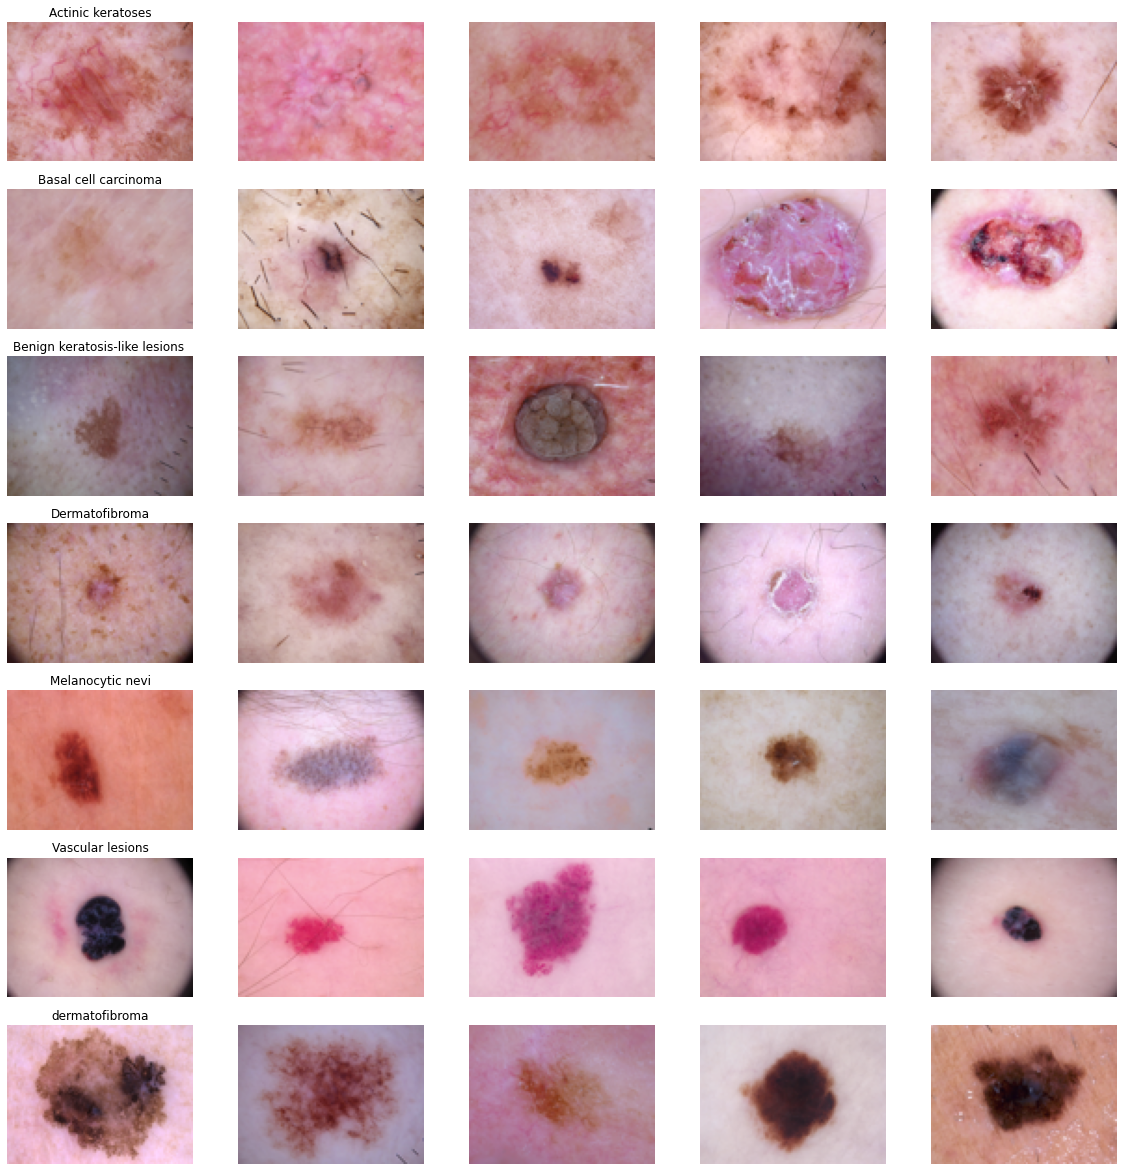

In [13]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         image_dataframe.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Splitting the complete data into training and testing datasets in 80/20 ratio

In [0]:
features=image_dataframe.drop(columns=['cell_type_idx'],axis=1)
target=image_dataframe['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

Noramlizing the data

In [0]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [0]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [0]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [19]:
y_test[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# Neural Networks

I want to build a image classifier model using convolutional neural networks and classify a skin image into one of 7 labels mentioned above. Lets get started by installing necessary packages and import features from Keras & Tensorflow libraries.

In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob
import seaborn as sns
import pandas as pd
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import Activation, Dropout
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import adam
from keras.utils import np_utils


I defined 7 labels and expecting our output to be classified into one of 7 labels. I also defined both optimization functions:


1.   Stochaistic Gradient Descent(SGD)
2.   Adam Optimizer

Initially I will assign default learning rate of 0.01 for both optimizers and then we will tune according to our desired output.



In [0]:
num_classes = len(lesion_type_dict)
sgd = keras.optimizers.SGD(lr=0.01)
opt = adam(lr=0.01)


# CNN Architecture

In [29]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(75,100,3)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 98, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 96, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 71, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 46, 64)        1

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Data generators are on-the-fly image transformers and are the recommended way of providing image data to models in Keras. They let you work with on-disk image data too large to fit all at once in-memory. And they allow you to preprocess the images your model sees with random image transformations and standardizations, a key technique for improving model performance.


In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [32]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
721/721 [==============================] - 21s 29ms/step - loss: 1.5024 - accuracy: 0.5250 - val_loss: 0.9961 - val_accuracy: 0.6271
Epoch 2/50
721/721 [==============================] - 20s 28ms/step - loss: 1.0623 - accuracy: 0.6399 - val_loss: 0.8444 - val_accuracy: 0.6765
Epoch 3/50
721/721 [==============================] - 20s 28ms/step - loss: 0.9597 - accuracy: 0.6700 - val_loss: 0.8277 - val_accuracy: 0.6680
Epoch 4/50
721/721 [==============================] - 20s 28ms/step - loss: 0.9192 - accuracy: 0.6802 - val_loss: 0.8469 - val_accuracy: 0.6805
Epoch 5/50
721/721 [==============================] - 21s 29ms/step - loss: 0.9021 - accuracy: 0.6835 - val_loss: 0.7898 - val_accuracy: 0.6895
Epoch 6/50
721/721 [==============================] - 21s 29ms/step - loss: 0.8726 - accuracy: 0.6864 - val_loss: 0.7509 - val_accuracy: 0.7124
Epoch 7/50
721/721 [==============================] - 21s 29

In [33]:
# Measure accuracy and loss after training
final_loss, final_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

63/63 [==============================] - 1s 10ms/step - loss: 0.6678 - accuracy: 0.7539
Final loss: 0.67
Final accuracy: 75.39%


In [34]:
# list all data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


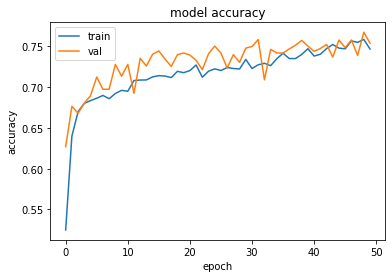

In [35]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

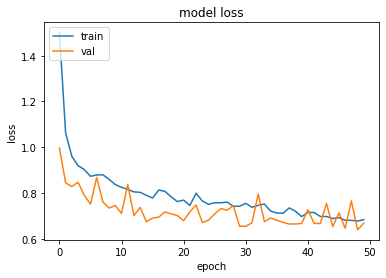

In [36]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Confusion Matrix**

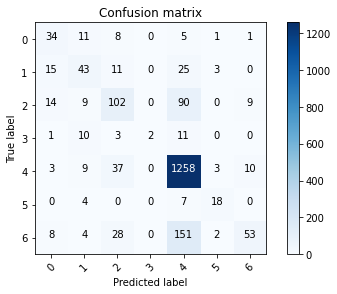

In [39]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

Text(0, 0.5, 'Fraction classified incorrectly')

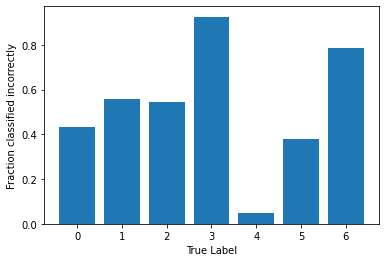

In [47]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [48]:
unique, counts = np.unique(Y_true, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0   60]
 [   1   97]
 [   2  224]
 [   3   27]
 [   4 1320]
 [   5   29]
 [   6  246]]
ERROR! Session/line number was not unique in database. History logging moved to new session 59


**Visualizing Filters**

In [52]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 32)
conv2d_2 (3, 3, 32, 64)
conv2d_3 (3, 3, 64, 128)


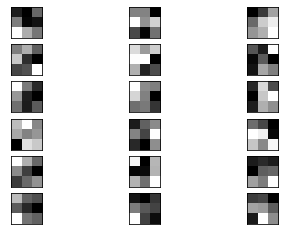

In [54]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'conv2d_3'
filter_index = 0 # Which filter in this block would you like to visualise?

# Grab the filters and biases for that layer
filters, biases = layer_dict[layer_name].get_weights()

# Normalize filter values to a range of 0 to 1 so we can visualize them
f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters - f_min) / (f_max - f_min)

# Plot first few filters
n_filters, index = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    
    # Plot each channel separately
    for j in range(3):

        ax = plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, j], cmap='gray')
        index += 1
        
plt.show()

Visualising Feature Maps

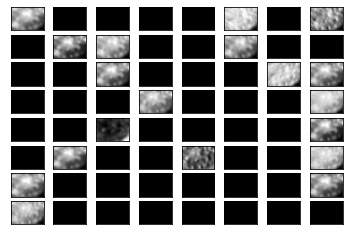

In [89]:
model = tf.compat.v1.keras.Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = x_test[642]
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Apply the model to the image
feature_maps = model.predict(image)

square = 8
index = 1
for _ in range(square):
	for _ in range(square):
        
		ax = plt.subplot(square, square, index)
		ax.set_xticks([])
		ax.set_yticks([])

		plt.imshow(feature_maps[0, :, :, index-1], cmap='gray')
		index += 1
        
plt.show()